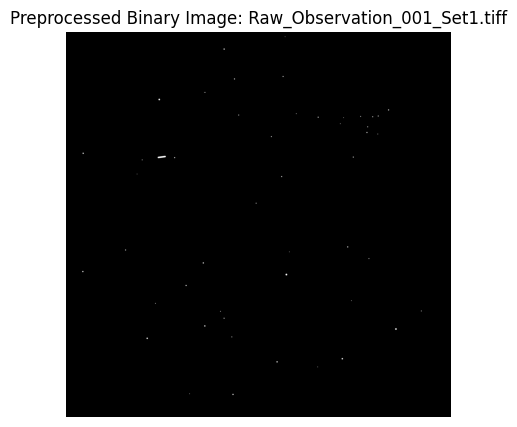

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Set your image directory path
image_dir = Path(r"Datasets\Raw_Images")  # <-- change this to your actual folder path
image_paths = list(image_dir.glob("*.tiff"))
output_dir = Path(r"Processed")  # <-- change this to your actual folder path
# Output dictionary for processed binary images
preprocessed_images = {}
images_8bit = {}
pre_thres={}
# CLAHE setup
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

for path in image_paths:
    # Load 16-bit grayscale image
    img_16 = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)

    if img_16 is None:
        print(f"Failed to load {path.name}")
        continue

    # Step 1: Normalize to 8-bit
    img_norm = cv2.normalize(img_16, None, 0, 255, cv2.NORM_MINMAX)
    img_8bit =  img_norm.astype(np.uint8)
    images_8bit[path.name] = img_8bit
    # Step 2: Gaussian Blur
    bilateral_filtered = cv2.bilateralFilter(img_8bit, 9, 75, 75)  # Adjust parameters as needed

    # Step 3: CLAHE
    clahe_img = clahe.apply(bilateral_filtered)
    pre_thres[path.name] = clahe_img
    hist = cv2.calcHist([clahe_img], [0], None, [256], [0, 256])
    hist = hist / hist.sum()  # Normalize to sum to 1 (optional)

# Step 3: Calculate the Cumulative Histogram
    cumulative_hist = np.cumsum(hist)

    # Step 4: Find the bin corresponding to the median
    median_bin = np.searchsorted(cumulative_hist, 0.5)

    
    # Step 4: Binary Thresholding
    _, binary = cv2.threshold(clahe_img, median_bin*2, 255, cv2.THRESH_BINARY)

    # Save binary output
    preprocessed_images[path.name] = binary
    output_path = output_dir / f"{path.stem}_binary.tiff"  # Save with _binary suffix
    cv2.imwrite(str(output_path), binary)


# Display one result for verification
sample_key = list(preprocessed_images.keys())[0]
plt.figure(figsize=(12, 5))
plt.imshow(preprocessed_images[sample_key], cmap='gray')
plt.title(f"Preprocessed Binary Image: {sample_key}")
plt.axis('off')
plt.show()


In [ ]:
import cv2
import numpy as np
import pandas as pd
from skimage.measure import label, regionprops
from pathlib import Path
import os

# Parameters
area_threshold = 75  # minimum area to consider
eccentricity_threshold = 0.9  # classify based on this
min_dist = 10  # pixels to consider two centroids "too close"

# Setup paths
binary_dir = preprocessed_images  # dictionary: {filename: binary_image}
originals = images_8bit           # dictionary: {filename: 8bit_original}
stars_dir = Path("stars-images")
streaks_dir = Path("streaks-images")
stars_dir.mkdir(exist_ok=True)
streaks_dir.mkdir(exist_ok=True)

# Output data
all_eccentricity_data = []
all_image_stats = []

for image_name, binary in binary_dir.items():
    original = preprocessed_images[image_name]

    # Label connected components
    labels = label(binary)
    regions = regionprops(labels)

    star_objects = []
    streak_objects = []
    filtered_regions = []

    for region in regions:
        if region.area < area_threshold:
            continue

        centroid = region.centroid
        if any(np.linalg.norm(np.array(centroid) - np.array(r.centroid)) < min_dist for r in filtered_regions):
            continue  # Filter duplicates

        filtered_regions.append(region)
        eccentricity = region.eccentricity
        bbox = region.bbox
        x, y = int(centroid[0]), int(centroid[1])

        # Crop the region from original image
        crop = original[bbox[0]:bbox[2], bbox[1]:bbox[3]]

        if eccentricity < eccentricity_threshold:
            obj_type = "star"
            star_objects.append(region)
            save_path = stars_dir / f"star_{image_name[:-5]}_{x}_{y}.png"
        else:
            obj_type = "streak"
            streak_objects.append(region)
            save_path = streaks_dir / f"streak_{image_name[:-5]}_{x}_{y}.png"

        # Save cropped image
        cv2.imwrite(str(save_path), crop)

        # Log object data
        all_eccentricity_data.append({
            'image': image_name,
            'object_type': obj_type,
            'object_name': os.path.basename(save_path),
            'eccentricity': eccentricity
        })

    # Log image-wise summary
    all_image_stats.append({
        'image_name': image_name,
        'no_of_stars': len(star_objects),
        'no_of_streaks': len(streak_objects)
    })

# Save logs as CSVs
pd.DataFrame(all_eccentricity_data).to_csv('eccentricity_data.csv', index=False)
pd.DataFrame(all_image_stats).to_csv('image_stats.csv', index=False)

print("\n✅ Connected components processed. Cropped images and CSVs saved.")


In [21]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import os

# Directories
star_dir = Path("stars-images")
streak_dir = Path("streaks-images")

# Output list
feature_list = []

# Function to extract features from a grayscale image
def extract_features(image_path, label=None):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    # Threshold for contour detection
    _, thresh = cv2.threshold(img, 30, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None

    cnt = max(contours, key=cv2.contourArea)  # use largest contour
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / h if h != 0 else 0
    area = cv2.contourArea(cnt)

    # Eccentricity
    M = cv2.moments(cnt)
    if M['mu20'] + M['mu02'] == 0:
        eccentricity = 0
    else:
        numerator = (M['mu20'] - M['mu02'])**2 + 4*M['mu11']**2
        denominator = (M['mu20'] + M['mu02'])**2
        eccentricity = np.sqrt(numerator / denominator) if denominator != 0 else 0

    # Hu Moments (log scaled)
    hu = cv2.HuMoments(M).flatten()
    hu = -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)

    # Combine features
    features = {
        'file': image_path.name,
        'label': label,
        'aspect_ratio': aspect_ratio,
        'area': area,
        'eccentricity': eccentricity
    }

    for i, h in enumerate(hu):
        features[f'hu{i+1}'] = h

    return features

# Extract from star images
for path in star_dir.glob("*.png"):
    feat = extract_features(path, label="star")
    if feat: feature_list.append(feat)

# Extract from streak images
for path in streak_dir.glob("*.png"):
    feat = extract_features(path, label="streak")
    if feat: feature_list.append(feat)

# Convert to DataFrame
features_df = pd.DataFrame(feature_list)
features_df.to_csv("component_features.csv", index=False)

print("✅ Feature extraction complete. Saved to 'component_features.csv'.")


✅ Feature extraction complete. Saved to 'component_features.csv'.


In [22]:
import cv2
import numpy as np
import pandas as pd
from skimage.measure import label, regionprops
from pathlib import Path
import os

# Parameters
area_threshold = 75  # minimum area to consider
eccentricity_threshold = 0.9  # classify based on this
min_dist = 10  # pixels to consider two centroids "too close"

# Setup paths
binary_dir = preprocessed_images  # dictionary: {filename: binary_image}
originals = images_8bit           # dictionary: {filename: 8bit_original}
output_dir = Path("annotated_images")
stars_dir = Path("stars-images")
streaks_dir = Path("streaks-images")
output_dir.mkdir(exist_ok=True)
stars_dir.mkdir(exist_ok=True)
streaks_dir.mkdir(exist_ok=True)

# Output data
all_eccentricity_data = []
all_image_stats = []

for image_name, binary in binary_dir.items():
    original = originals[image_name]
    
    # Convert grayscale to BGR for color annotations if needed
    if len(original.shape) == 2:
        annotated_img = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    else:
        annotated_img = original.copy()
    
    # Label connected components
    labels = label(binary)
    regions = regionprops(labels)

    star_objects = []
    streak_objects = []
    filtered_regions = []

    for region in regions:
        if region.area < area_threshold:
            continue

        centroid = region.centroid
        if any(np.linalg.norm(np.array(centroid) - np.array(r.centroid)) < min_dist for r in filtered_regions):
            continue  # Filter duplicates

        filtered_regions.append(region)
        eccentricity = region.eccentricity
        bbox = region.bbox
        y1, x1, y2, x2 = bbox  # Note: regionprops uses (min_row, min_col, max_row, max_col)
        
        # Convert to (x,y,w,h) format for OpenCV
        x, y, w, h = x1, y1, x2 - x1, y2 - y1
        
        # Crop the region from original image
        crop = original[y1:y2, x1:x2]

        if eccentricity < eccentricity_threshold:
            obj_type = "star"
            color = (0, 255, 0)  # Green for stars
            star_objects.append(region)
            save_path = stars_dir / f"star_{image_name[:-5]}_{x}_{y}.png"
        else:
            obj_type = "streak"
            color = (0, 0, 255)  # Red for streaks
            streak_objects.append(region)
            save_path = streaks_dir / f"streak_{image_name[:-5]}_{x}_{y}.png"

        # Draw bounding box
        cv2.rectangle(annotated_img, (x1, y1), (x2, y2), color, 2)
        
        # Add label text
        label_text = f"{obj_type} {eccentricity:.2f}"
        cv2.putText(annotated_img, label_text, (x1, y1 - 10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
        
        # Save cropped image
        cv2.imwrite(str(save_path), crop)

        # Log object data
        all_eccentricity_data.append({
            'image': image_name,
            'object_type': obj_type,
            'object_name': os.path.basename(save_path),
            'eccentricity': eccentricity,
            'bbox_x':    x1,
            'bbox_y': y1,
            'bbox_width': w,
            'bbox_height': h
        })

    # Save annotated image
    annotated_path = output_dir / f"annotated_{image_name}"
    cv2.imwrite(str(annotated_path), annotated_img)
    
    # Log image-wise summary
    all_image_stats.append({
        'image_name': image_name,
        'no_of_stars': len(star_objects),
        'no_of_streaks': len(streak_objects)
    })

# Save logs as CSVs
pd.DataFrame(all_eccentricity_data).to_csv('eccentricity_data.csv', index=False)
pd.DataFrame(all_image_stats).to_csv('image_stats.csv', index=False)

print("\n✅ Processing complete. Annotated images, cropped objects, and CSVs saved.")


✅ Processing complete. Annotated images, cropped objects, and CSVs saved.


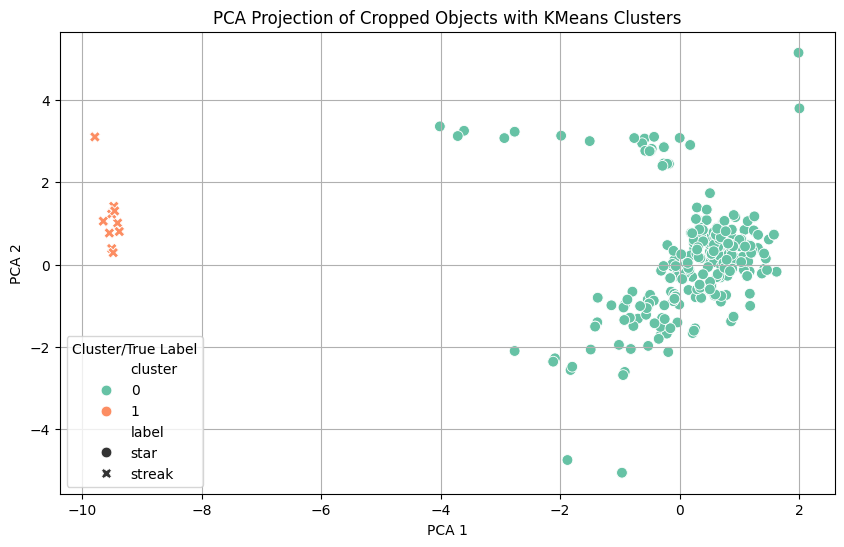

In [25]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# Load extracted features
df = pd.read_csv("component_features.csv")

# Preserve true labels for comparison
true_labels = df['label']

# Select only numerical features (ignore filename + label)
X = df.drop(columns=['file', 'label'])

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA to 2 components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['pca1'] = X_pca[:, 0]
df['pca2'] = X_pca[:, 1]

X_train, X_test, y_train, y_test = train_test_split(X_scaled, true_labels, test_size=0.2, random_state=42)

# KMeans clustering (2 clusters)
kmeans = KMeans(n_clusters=2, random_state=4)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', style=true_labels, palette='Set2', s=60)
plt.title("PCA Projection of Cropped Objects with KMeans Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='Cluster/True Label')
plt.grid(True)
plt.show()


In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Majority voting to map cluster ID → actual label (star/streak)
cluster_to_label = {}

for cluster_id in df['cluster'].unique():
    actual_labels = df[df['cluster'] == cluster_id]['label']
    most_common = actual_labels.value_counts().idxmax()
    cluster_to_label[cluster_id] = most_common

print("🔁 Cluster-to-Label Mapping (Majority Vote):", cluster_to_label)

# Map clusters to predicted labels
df['predicted_label'] = df['cluster'].map(cluster_to_label)

# Confusion Matrix
cm = confusion_matrix(df['label'], df['predicted_label'], labels=['star', 'streak'])
report = classification_report(df['label'], df['predicted_label'], target_names=['star', 'streak'])

print("\n🧾 Confusion Matrix:")
print(pd.DataFrame(cm, index=['Actual Star', 'Actual Streak'], columns=['Predicted Star', 'Predicted Streak']))

print("\n📊 Classification Report:")
print(report)


🔁 Cluster-to-Label Mapping (Majority Vote): {np.int32(0): 'star', np.int32(1): 'streak'}

🧾 Confusion Matrix:
               Predicted Star  Predicted Streak
Actual Star               383                 0
Actual Streak               0                10

📊 Classification Report:
              precision    recall  f1-score   support

        star       1.00      1.00      1.00       383
      streak       1.00      1.00      1.00        10

    accuracy                           1.00       393
   macro avg       1.00      1.00      1.00       393
weighted avg       1.00      1.00      1.00       393



In [27]:
# Select relevant columns for export
output_df = df[['file', 'label', 'predicted_label', 'cluster', 'pca1', 'pca2']]

# Save to CSV
output_df.to_csv("clustered_predictions.csv", index=False)

print("✅ Clustered predictions saved to 'clustered_predictions.csv'.")


✅ Clustered predictions saved to 'clustered_predictions.csv'.


**USED THRESHOLD PATCHES TO TRAIN**

In [37]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import random
random_seed = 4 
random.seed(random_seed)
 
np.random.seed(random_seed)
 
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)  
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False 

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# --- DATASET ---
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 1 channel input
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# ImageFolder assumes each class is in a folder
dataset = datasets.ImageFolder(root=r'Data\Dataset_thresh', transform=transform)

# Print class mapping
print("✅ Classes:", dataset.classes)  # ['stars-images', 'streaks-images']

# --- SPLIT ---
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])


from torch.utils.data import WeightedRandomSampler
from collections import Counter

train_targets = [dataset.targets[i] for i in train_ds.indices]
class_sample_count = Counter(train_targets)

# Inverse frequency for sampling
weights = [1.0 / class_sample_count[t] for t in train_targets]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# DataLoader with sampler
train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_ds, batch_size=32)

    
# --- MODEL ---
resnet18 = models.resnet18(pretrained=True)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 2)
model = resnet18.to(device)

# --- TRAINING SETUP ---
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 5

best_val_acc = 0.0

# --- TRAIN LOOP ---
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)

    # --- VALIDATION ---
    model.eval()
    correct = 0
    total = 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_train_loss:.4f} - Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_starstreak_model.pth")

# --- EVALUATION ---
print("\n📊 Final Classification Report:")
print(classification_report(val_labels, val_preds, target_names=dataset.classes))


✅ Classes: ['stars', 'streaks']


c:\projects\Streak-and-Stars\stars\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\projects\Streak-and-Stars\stars\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5 - Loss: 0.0474 - Val Acc: 0.9812
Epoch 2/5 - Loss: 0.0005 - Val Acc: 0.9906
Epoch 3/5 - Loss: 0.0002 - Val Acc: 0.9906
Epoch 4/5 - Loss: 0.0001 - Val Acc: 0.9906
Epoch 5/5 - Loss: 0.0001 - Val Acc: 1.0000

📊 Final Classification Report:
              precision    recall  f1-score   support

       stars       1.00      1.00      1.00       209
     streaks       1.00      1.00      1.00         4

    accuracy                           1.00       213
   macro avg       1.00      1.00      1.00       213
weighted avg       1.00      1.00      1.00       213



**RAW DATASET**

*without augment*

In [38]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import random
random_seed = 4 
random.seed(random_seed)
 
np.random.seed(random_seed)
 
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)  
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False 

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# --- DATASET ---
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 1 channel input
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# ImageFolder assumes each class is in a folder
dataset = datasets.ImageFolder(root=r'Data\Dataset_Raw', transform=transform)

# Print class mapping
print("✅ Classes:", dataset.classes)  # ['stars-images', 'streaks-images']

# --- SPLIT ---
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])


from torch.utils.data import WeightedRandomSampler
from collections import Counter

train_targets = [dataset.targets[i] for i in train_ds.indices]
class_sample_count = Counter(train_targets)

# Inverse frequency for sampling
weights = [1.0 / class_sample_count[t] for t in train_targets]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# DataLoader with sampler
train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_ds, batch_size=32)

    
# --- MODEL ---
resnet18 = models.resnet18(pretrained=True)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 2)
model = resnet18.to(device)

# --- TRAINING SETUP ---
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 5

best_val_acc = 0.0

# --- TRAIN LOOP ---
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)

    # --- VALIDATION ---
    model.eval()
    correct = 0
    total = 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_train_loss:.4f} - Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_starstreak_model.pth")

# --- EVALUATION ---
print("\n📊 Final Classification Report:")
print(classification_report(val_labels, val_preds, target_names=dataset.classes))


✅ Classes: ['stars', 'streaks']


c:\projects\Streak-and-Stars\stars\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\projects\Streak-and-Stars\stars\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5 - Loss: 0.0308 - Val Acc: 0.9973
Epoch 2/5 - Loss: 0.0070 - Val Acc: 1.0000
Epoch 3/5 - Loss: 0.0004 - Val Acc: 1.0000
Epoch 4/5 - Loss: 0.0001 - Val Acc: 1.0000
Epoch 5/5 - Loss: 0.0072 - Val Acc: 1.0000

📊 Final Classification Report:
              precision    recall  f1-score   support

       stars       1.00      1.00      1.00       364
     streaks       1.00      1.00      1.00         6

    accuracy                           1.00       370
   macro avg       1.00      1.00      1.00       370
weighted avg       1.00      1.00      1.00       370



In [76]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from sklearn.metrics import classification_report
from collections import Counter

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- MODEL CLASS ---
class StarStreakClassifier(nn.Module):
    def __init__(self):
        super(StarStreakClassifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, 3)
        
    def forward(self, x):
        return self.model(x)

# --- DATASET ---
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset with error handling
try:
    dataset = datasets.ImageFolder(root='Data/Dataset_Raw_Augment', transform=transform)
    print("✅ Classes:", dataset.classes)
    print(f"✅ Total samples: {len(dataset)}")
    
    if len(dataset) == 0:
        raise ValueError("Dataset is empty! Check your 'Data' directory structure.")
        
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    exit()

# --- SPLIT ---
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Add check for minimum dataset size
if train_size == 0 or val_size == 0:
    raise ValueError("Not enough samples for training and validation split")

train_ds, val_ds = random_split(dataset, [train_size, val_size])

# --- SAMPLER ---
# Get labels from the original dataset (not the split)

train_targets = [dataset.targets[i] for i in train_ds.indices]
class_sample_count = Counter(train_targets)

print(f"✅ Class sample counts: {class_sample_count}")
# Inverse frequency for sampling
weights = [1.0 / class_sample_count[t] for t in train_targets]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# DataLoader with sampler
train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_ds, batch_size=32)

print(f"\nDataset sizes - Train: {len(train_ds)}, Val: {len(val_ds)}")


✅ Classes: ['stars', 'streaks']
✅ Total samples: 2225
✅ Class sample counts: Counter({0: 1461, 1: 319})

Dataset sizes - Train: 1780, Val: 445


In [77]:
# --- MODEL INITIALIZATION ---
model = StarStreakClassifier().to(device)

# --- TRAINING SETUP ---
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 5
best_val_acc = 0.0

# --- TRAIN LOOP ---
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)

    # --- VALIDATION ---
    model.eval()
    correct = 0
    total = 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_train_loss:.4f} - Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_starstreak_model.pth")

# --- EVALUATION ---
print("\n📊 Final Classification Report:")
print(classification_report(val_labels, val_preds, target_names=dataset.classes))


c:\projects\Streak-and-Stars\stars\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\projects\Streak-and-Stars\stars\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5 - Loss: 0.0885 - Val Acc: 0.9820
Epoch 2/5 - Loss: 0.0069 - Val Acc: 1.0000
Epoch 3/5 - Loss: 0.0072 - Val Acc: 1.0000
Epoch 4/5 - Loss: 0.0011 - Val Acc: 1.0000
Epoch 5/5 - Loss: 0.0012 - Val Acc: 1.0000

📊 Final Classification Report:
              precision    recall  f1-score   support

       stars       1.00      1.00      1.00       359
     streaks       1.00      1.00      1.00        86

    accuracy                           1.00       445
   macro avg       1.00      1.00      1.00       445
weighted avg       1.00      1.00      1.00       445



In [79]:
from torch.utils.data import Subset
import numpy as np

# --- MANUAL UNDERSAMPLING ---
# Extract targets from training set
targets = [dataset.targets[i] for i in train_ds.indices]
class_sample_count = Counter(targets)
print("Original train class distribution:", class_sample_count)

# Find the minority class count
min_class_count = min(class_sample_count.values())

# Build balanced indices
balanced_indices = []
class_indices = {cls: [] for cls in class_sample_count}

for idx in train_ds.indices:
    label = dataset.targets[idx]
    class_indices[label].append(idx)

# Undersample each class
for cls, indices in class_indices.items():
    undersampled = np.random.choice(indices, min_class_count, replace=False)
    balanced_indices.extend(undersampled)

# Create new subset with balanced indices
train_ds = Subset(dataset, balanced_indices)
print("Balanced train class distribution:",
      Counter([dataset.targets[i] for i in train_ds.indices]))

Original train class distribution: Counter({0: 1461, 1: 319})
Balanced train class distribution: Counter({0: 319, 1: 319})


In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
from torch.utils.data import Subset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
from collections import Counter
import matplotlib.pyplot as plt

# Force CPU usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available = lambda: False  # Override CUDA check

# --- MODEL CLASS ---
class StarStreakClassifier(nn.Module):
    def __init__(self):
        super(StarStreakClassifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, 3)
        
    def forward(self, x):
        return self.model(x)

# --- CALLBACKS ---
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > (self.best_loss - self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

class LRScheduler:
    def __init__(self, optimizer, patience=3, factor=0.1, min_lr=1e-6):
        self.optimizer = optimizer
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self._reduce_lr()
                self.counter = 0

    def _reduce_lr(self):
        for param_group in self.optimizer.param_groups:
            old_lr = param_group['lr']
            new_lr = max(old_lr * self.factor, self.min_lr)
            param_group['lr'] = new_lr
            print(f"\nReducing learning rate from {old_lr:.2e} to {new_lr:.2e}")

# --- DATASET ---
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset
try:
    dataset = datasets.ImageFolder(root='Data/Dataset_Raw_Augment', transform=transform)
    print("✅ Classes:", dataset.classes)
    print(f"✅ Total samples: {len(dataset)}")
    
    if len(dataset) == 0:
        raise ValueError("Dataset is empty!")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    exit()

# --- SPLIT ---
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# --- BALANCE TRAINING SET ---
targets = [dataset.targets[i] for i in train_ds.indices]
class_sample_count = Counter(targets)
min_class_count = min(class_sample_count.values())

balanced_indices = []
class_indices = {cls: [] for cls in class_sample_count}

for idx in train_ds.indices:
    label = dataset.targets[idx]
    class_indices[label].append(idx)

for cls, indices in class_indices.items():
    balanced_indices.extend(np.random.choice(indices, min_class_count, replace=False))

train_ds = Subset(dataset, balanced_indices)

# --- DATALOADERS ---
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

print(f"\nDataset sizes - Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

# --- TRAINING SETUP ---
model = StarStreakClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
early_stopping = EarlyStopping(patience=7, min_delta=0.001)
lr_scheduler = LRScheduler(optimizer)

# --- TRAINING METRICS TRACKING ---
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0.0
num_epochs = 30

for epoch in range(num_epochs):
    # --- TRAIN PHASE ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    
    # --- VALIDATION PHASE ---
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    val_preds, val_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_acc = correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    
    # --- CALLBACKS ---
    early_stopping(epoch_val_loss)
    lr_scheduler(epoch_val_loss)
    
    # --- PRINT PROGRESS ---
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    print(f"Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Save best model
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), 'best_model_augment_noiseless.pth')
        
    # Early stopping check
    if early_stopping.early_stop:
        print(f"⏹ Early stopping triggered after {epoch+1} epochs")
        break

# --- PLOT TRAINING CURVES ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_metrics.png')
plt.close()


✅ Classes: ['stars', 'streaks']
✅ Total samples: 2225

Dataset sizes - Train: 552, Val: 333, Test: 335

Epoch 1/30
Train Loss: 0.1973 | Val Loss: 0.7370
Train Acc: 0.9221 | Val Acc: 0.6667
Learning Rate: 1.00e-04

Epoch 2/30
Train Loss: 0.0114 | Val Loss: 0.7273
Train Acc: 0.9982 | Val Acc: 0.6126
Learning Rate: 1.00e-04

Epoch 3/30
Train Loss: 0.0428 | Val Loss: 0.0056
Train Acc: 0.9891 | Val Acc: 1.0000
Learning Rate: 1.00e-04

Epoch 4/30
Train Loss: 0.0148 | Val Loss: 0.0028
Train Acc: 0.9928 | Val Acc: 1.0000
Learning Rate: 1.00e-04

Epoch 5/30
Train Loss: 0.0033 | Val Loss: 0.0022
Train Acc: 1.0000 | Val Acc: 1.0000
Learning Rate: 1.00e-04

Epoch 6/30
Train Loss: 0.0021 | Val Loss: 0.0016
Train Acc: 1.0000 | Val Acc: 1.0000
Learning Rate: 1.00e-04

Epoch 7/30
Train Loss: 0.0015 | Val Loss: 0.0011
Train Acc: 1.0000 | Val Acc: 1.0000
Learning Rate: 1.00e-04

Epoch 8/30
Train Loss: 0.0054 | Val Loss: 0.0047
Train Acc: 0.9982 | Val Acc: 1.0000
Learning Rate: 1.00e-04

Epoch 9/30
Train

FileNotFoundError: [Errno 2] No such file or directory: 'best_model.pth'

In [83]:

# --- FINAL EVALUATION ---
model.load_state_dict(torch.load('best_model_augment_noiseless.pth'))
model.eval()

# Test set evaluation
test_preds, test_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

print("\n📊 Final Validation Report:")
print(classification_report(val_labels, val_preds, target_names=dataset.classes))

print("\n📊 Test Set Report:")
print(classification_report(test_labels, test_preds, target_names=dataset.classes))


📊 Final Validation Report:
              precision    recall  f1-score   support

       stars       1.00      1.00      1.00       262
     streaks       1.00      1.00      1.00        71

    accuracy                           1.00       333
   macro avg       1.00      1.00      1.00       333
weighted avg       1.00      1.00      1.00       333


📊 Test Set Report:
              precision    recall  f1-score   support

       stars       1.00      1.00      1.00       277
     streaks       1.00      1.00      1.00        58

    accuracy                           1.00       335
   macro avg       1.00      1.00      1.00       335
weighted avg       1.00      1.00      1.00       335



**ADDING NOISE**

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
from torch.utils.data import Subset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
from collections import Counter
import matplotlib.pyplot as plt

# Force CPU usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available = lambda: False  # Override CUDA check

# --- MODEL CLASS ---
class StarStreakClassifier(nn.Module):
    def __init__(self):
        super(StarStreakClassifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, 4)
        
    def forward(self, x):
        return self.model(x)

# --- CALLBACKS ---
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > (self.best_loss - self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

class LRScheduler:
    def __init__(self, optimizer, patience=3, factor=0.1, min_lr=1e-6):
        self.optimizer = optimizer
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self._reduce_lr()
                self.counter = 0

    def _reduce_lr(self):
        for param_group in self.optimizer.param_groups:
            old_lr = param_group['lr']
            new_lr = max(old_lr * self.factor, self.min_lr)
            param_group['lr'] = new_lr
            print(f"\nReducing learning rate from {old_lr:.2e} to {new_lr:.2e}")

# --- DATASET ---
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset
try:
    dataset = datasets.ImageFolder(root='Data/Dataset_Raw_Augment_Noise', transform=transform)
    print("✅ Classes:", dataset.classes)
    print(f"✅ Total samples: {len(dataset)}")
    
    if len(dataset) == 0:
        raise ValueError("Dataset is empty!")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    exit()

# --- SPLIT ---
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# --- BALANCE TRAINING SET ---
targets = [dataset.targets[i] for i in train_ds.indices]

class_sample_count = Counter(targets)
min_class_count = min(class_sample_count.values())

print("Original class counts:", class_sample_count)
balanced_indices = []
class_indices = {cls: [] for cls in class_sample_count}

for idx in train_ds.indices:
    label = dataset.targets[idx]
    class_indices[label].append(idx)

for cls, indices in class_indices.items():
    balanced_indices.extend(np.random.choice(indices, min_class_count, replace=False))
balanced_targets = [dataset.targets[i] for i in balanced_indices]
balanced_class_count = Counter(balanced_targets)
print("Balanced class counts:", balanced_class_count)
train_ds = Subset(dataset, balanced_indices)

# --- DATALOADERS ---
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

print(f"\nDataset sizes - Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

# --- TRAINING SETUP ---
model = StarStreakClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
early_stopping = EarlyStopping(patience=7, min_delta=0.001)
lr_scheduler = LRScheduler(optimizer)

# --- TRAINING METRICS TRACKING ---
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0.0
num_epochs = 30

for epoch in range(num_epochs):
    # --- TRAIN PHASE ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    
    # --- VALIDATION PHASE ---
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    val_preds, val_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_acc = correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    
    # --- CALLBACKS ---
    early_stopping(epoch_val_loss)
    lr_scheduler(epoch_val_loss)
    
    # --- PRINT PROGRESS ---
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    print(f"Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Save best model
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), 'best_model_augment_noise.pth')
        
    # Early stopping check
    if early_stopping.early_stop:
        print(f"⏹ Early stopping triggered after {epoch+1} epochs")
        break

# --- PLOT TRAINING CURVES ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_metrics.png')
plt.close()


✅ Classes: ['background', 'noise', 'stars', 'streaks']
✅ Total samples: 3325
Balanced class counts: Counter({1: 288, 2: 288, 0: 288, 3: 288})

Dataset sizes - Train: 1152, Val: 498, Test: 500


KeyboardInterrupt: 

In [ ]:

# --- FINAL EVALUATION ---
model.load_state_dict(torch.load('best_model_augment_noise.pth'))
model.eval()

# Test set evaluation
test_preds, test_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

print("\n📊 Final Validation Report:")
print(classification_report(val_labels, val_preds, target_names=dataset.classes))

print("\n📊 Test Set Report:")
print(classification_report(test_labels, test_preds, target_names=dataset.classes))

In [ ]:
import cv2
import numpy as np
import torch
from skimage.measure import label, regionprops
from pathlib import Path
import os
from PIL import Image
from torchvision import transforms

# 1. Load your trained model
class StarStreakClassifier(nn.Module):
    def __init__(self):
        super(StarStreakClassifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, )
        
    def forward(self, x):
        return self.model(x)


# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StarStreakClassifier().to(device)

# Load trained weights (handle the model. prefix if needed)
state_dict = torch.load("best_starstreak_model.pth", map_location=device)
if any(k.startswith('model.') for k in state_dict.keys()):
    state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}
model.load_state_dict(state_dict)
model.eval()

# 2. Define image transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 3. Detection and classification parameters
area_threshold = 75  # Minimum area to consider
min_dist = 10  # Minimum distance between objects

def classify_patch(patch):
    """Classify a single image patch"""
    patch_pil = Image.fromarray(patch)
    tensor = transform(patch_pil).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(tensor)
        _, predicted = torch.max(outputs, 1)
        return predicted.item()  # 0=star, 1=streak

def process_image(image_path, output_dir):
    """Process a single image"""
    # Load and prepare image
    original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if original is None:
        print(f"Could not read image: {image_path}")
        return
    
    # Create binary image for detection (adjust threshold as needed)
    _, binary = cv2.threshold(original, 200, 255, cv2.THRESH_BINARY)
    
    # Prepare output image
    annotated_img = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    
    # Label connected components
    labels = label(binary)
    regions = regionprops(labels)
    
    for region in regions:
        if region.area < area_threshold:
            continue
            
        # Extract bounding box
        y1, x1, y2, x2 = region.bbox
        
        # Crop the region (with some padding)
        padding = 5
        x1 = max(0, x1 - padding)
        y1 = max(0, y1 - padding)
        x2 = min(original.shape[1], x2 + padding)
        y2 = min(original.shape[0], y2 + padding)
        patch = original[y1:y2, x1:x2]
        
        # Classify the patch
        try:
            prediction = classify_patch(patch)
        except Exception as e:
            print(f"Error classifying patch: {e}")
            continue
            
        # Annotate based on prediction
        if prediction == 0:  # Star
            color = (0, 255, 0)  # Green
            label_text = "Star"
        else:  # Streak
            color = (0, 0, 255)  # Red
            label_text = "Streak"
        
        # Draw bounding box and label
        cv2.rectangle(annotated_img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(annotated_img, label_text, (x1, y1 - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    
    # Save annotated image
    output_path = os.path.join(output_dir, f"annotated_{os.path.basename(image_path)}")
    cv2.imwrite(output_path, annotated_img)
    print(f"Saved annotated image: {output_path}")

# 4. Process all images in a directory
input_dir = "Test"
output_dir = "."
os.makedirs(output_dir, exist_ok=True)

for image_file in os.listdir(input_dir):
    if image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff')):
        image_path = os.path.join(input_dir, image_file)
        process_image(image_path, output_dir)

print("Processing complete!")

RuntimeError: Error(s) in loading state_dict for StarStreakClassifier:
	Missing key(s) in state_dict: "model.conv1.weight", "model.bn1.weight", "model.bn1.bias", "model.bn1.running_mean", "model.bn1.running_var", "model.layer1.0.conv1.weight", "model.layer1.0.bn1.weight", "model.layer1.0.bn1.bias", "model.layer1.0.bn1.running_mean", "model.layer1.0.bn1.running_var", "model.layer1.0.conv2.weight", "model.layer1.0.bn2.weight", "model.layer1.0.bn2.bias", "model.layer1.0.bn2.running_mean", "model.layer1.0.bn2.running_var", "model.layer1.1.conv1.weight", "model.layer1.1.bn1.weight", "model.layer1.1.bn1.bias", "model.layer1.1.bn1.running_mean", "model.layer1.1.bn1.running_var", "model.layer1.1.conv2.weight", "model.layer1.1.bn2.weight", "model.layer1.1.bn2.bias", "model.layer1.1.bn2.running_mean", "model.layer1.1.bn2.running_var", "model.layer2.0.conv1.weight", "model.layer2.0.bn1.weight", "model.layer2.0.bn1.bias", "model.layer2.0.bn1.running_mean", "model.layer2.0.bn1.running_var", "model.layer2.0.conv2.weight", "model.layer2.0.bn2.weight", "model.layer2.0.bn2.bias", "model.layer2.0.bn2.running_mean", "model.layer2.0.bn2.running_var", "model.layer2.0.downsample.0.weight", "model.layer2.0.downsample.1.weight", "model.layer2.0.downsample.1.bias", "model.layer2.0.downsample.1.running_mean", "model.layer2.0.downsample.1.running_var", "model.layer2.1.conv1.weight", "model.layer2.1.bn1.weight", "model.layer2.1.bn1.bias", "model.layer2.1.bn1.running_mean", "model.layer2.1.bn1.running_var", "model.layer2.1.conv2.weight", "model.layer2.1.bn2.weight", "model.layer2.1.bn2.bias", "model.layer2.1.bn2.running_mean", "model.layer2.1.bn2.running_var", "model.layer3.0.conv1.weight", "model.layer3.0.bn1.weight", "model.layer3.0.bn1.bias", "model.layer3.0.bn1.running_mean", "model.layer3.0.bn1.running_var", "model.layer3.0.conv2.weight", "model.layer3.0.bn2.weight", "model.layer3.0.bn2.bias", "model.layer3.0.bn2.running_mean", "model.layer3.0.bn2.running_var", "model.layer3.0.downsample.0.weight", "model.layer3.0.downsample.1.weight", "model.layer3.0.downsample.1.bias", "model.layer3.0.downsample.1.running_mean", "model.layer3.0.downsample.1.running_var", "model.layer3.1.conv1.weight", "model.layer3.1.bn1.weight", "model.layer3.1.bn1.bias", "model.layer3.1.bn1.running_mean", "model.layer3.1.bn1.running_var", "model.layer3.1.conv2.weight", "model.layer3.1.bn2.weight", "model.layer3.1.bn2.bias", "model.layer3.1.bn2.running_mean", "model.layer3.1.bn2.running_var", "model.layer4.0.conv1.weight", "model.layer4.0.bn1.weight", "model.layer4.0.bn1.bias", "model.layer4.0.bn1.running_mean", "model.layer4.0.bn1.running_var", "model.layer4.0.conv2.weight", "model.layer4.0.bn2.weight", "model.layer4.0.bn2.bias", "model.layer4.0.bn2.running_mean", "model.layer4.0.bn2.running_var", "model.layer4.0.downsample.0.weight", "model.layer4.0.downsample.1.weight", "model.layer4.0.downsample.1.bias", "model.layer4.0.downsample.1.running_mean", "model.layer4.0.downsample.1.running_var", "model.layer4.1.conv1.weight", "model.layer4.1.bn1.weight", "model.layer4.1.bn1.bias", "model.layer4.1.bn1.running_mean", "model.layer4.1.bn1.running_var", "model.layer4.1.conv2.weight", "model.layer4.1.bn2.weight", "model.layer4.1.bn2.bias", "model.layer4.1.bn2.running_mean", "model.layer4.1.bn2.running_var", "model.fc.weight", "model.fc.bias". 
	Unexpected key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.bn1.num_batches_tracked", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.bn2.num_batches_tracked", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.bn1.num_batches_tracked", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.bn2.num_batches_tracked", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.bn1.num_batches_tracked", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.bn2.num_batches_tracked", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.0.downsample.1.num_batches_tracked", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.bn1.num_batches_tracked", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.bn2.num_batches_tracked", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.bn1.num_batches_tracked", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.bn2.num_batches_tracked", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.0.downsample.1.num_batches_tracked", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.bn1.num_batches_tracked", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.bn2.num_batches_tracked", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.bn1.num_batches_tracked", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.bn2.num_batches_tracked", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.0.downsample.1.num_batches_tracked", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.bn1.num_batches_tracked", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.bn2.num_batches_tracked", "fc.weight", "fc.bias". 

^C
